In [1]:
# imports
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import json
#from random import randrange
from nltk.corpus import stopwords
import string
import pandas as pd
import pickle
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix,classification_report

# Elastic Search

Using elastic search to create a search engine.

Instructions:
1. Download elastic search from https://www.elastic.co/guide/en/elasticsearch/reference/current/install-elasticsearch.html
2. Run elastic search on localhost:9200, by running bin/elasticsearch.bat file

In [2]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

In [3]:
with open('reviewSelected100.json') as f:
    data = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + 
    "]")

In [4]:
unique_businesses = set()
for review in data:
    unique_businesses.add(review['business_id'])
print("Number of businesses: " + str(len(unique_businesses)))

Number of businesses: 153


In [5]:
es = Elasticsearch(HOST="http://localhost", PORT=9200)

In [6]:
# Define body of index
body={
    'settings': {
        'number_of_shards': 1,
        'number_of_replicas': 0,
        'index': {
          'sort.field': 'date',
          'sort.order': 'asc'
        },

        # custom analyzer
        'analysis': {
            'analyzer': {
                'review_analyzer': {
                    'type': 'custom',
                      'tokenizer': 'standard',
                      'filter': ['lowercase', 'english_stop', 'porter_stem']
                    }
                  },
            'filter': {
                'english_stop': { 
                'type': 'stop',
                'stopwords': '_english_'
                }
            }
        }
    },
    'mappings': {
        'properties': {
            'text': {
                'type': 'text',
                'analyzer': 'review_analyzer',
                'search_analyzer': 'review_analyzer'
            },
            'date': {
                'type': 'date',
                'format': 'yyyy-MM-dd HH:mm:ss'
            }
        }
    }
}

In [7]:
def review_generator(data):
    for review in data:
        yield {
                "_index": index_name,
                "_type": "_doc",
                "_id" : f"{review['review_id']}",
                "_source": review,
            }

Create the index and index all the reviews.

In [8]:
index_name = "review-index"
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body=body)
    helpers.bulk(es, review_generator(data))
    print("Index created")
else:
    print("Index already exists")

Index already exists


C:\Users\Grace\Anaconda3\envs\tensorflow_env\lib\site-packages\elasticsearch\connection\base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


---
## Load model and preprocess

Model has been trained and tested in a separate file 'NLP Assignment 1 - Sentiment Analysis Model.ipynb'.
We will be using this model to do sentiment analysis on the Yelp reviews.

Here, we load in the model and also define functions to preprocess the Yelp reviews before parsing them into the model to evaluate the sentiments of each business.

In [9]:
# loading of model
with open('modelAndVectorizer.pkl', 'rb') as f:
    lr, vectorizer = pickle.load(f)

In [10]:
def lowercase(text):
    return text.lower()

In [11]:
# Remove punctuations except hyphens
punctuations = string.punctuation.replace('-', '')

# Function to remove punctuations
def remove_punctuation(text, punctuations):
    return text.translate(str.maketrans('', '', punctuations))

In [12]:
# Remove digits
def remove_digits(text):
    return ''.join([i for i in text if not i.isdigit()])

In [13]:
# Tokenize the sentence
def tokenize(text):
    return word_tokenize(text)

In [14]:
# Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

# Do not include negation (not, no) in the stopwords
stopwords.remove("not")
stopwords.remove("no")

# Function to remove stopwords
def remove_stopwords(text, stopwords):
    result = []
    for word in text:
        if word not in stopwords:
            result.append(word)
    return result

In [15]:
# Stemming
ps = PorterStemmer()

def stemming(text, ps):
    return [ps.stem(word) for word in text]

In [16]:
# Combine back to a string

def mergeIntoString(text):
    return " ".join(text)

In [17]:
def preprocess(text, punctuations, stopwords, ps):
    text = lowercase(text)
    text = remove_punctuation(text, punctuations)
    text = remove_digits(text)
    text = tokenize(text)
    text = remove_stopwords(text, stopwords)
    text = stemming(text, ps)
    text = mergeIntoString(text)
    return text

---
## Sentiment analysis of business

Here, we define a function to retrieve all reviews of each business, before processing them with the functions defined above

In [18]:
# function to retrieve all business reviews + processing them
def retrieveBusinessReviews(businessID, es, index_name):
    doc_count = 0
    reviews = []
    query = {
        "size": 100,
        "query": {
            "match": {
                "business_id": businessID
            }
        }
    }
    # Make a search request
    res = es.search(index=index_name, body=query, scroll='2s')
    
    for doc in res['hits']['hits']:
        doc_count += 1
        reviews.append(doc['_source']['text'])
    
    old_scroll_id = res['_scroll_id']
    
    while len(res['hits']['hits']):
        res = es.scroll(scroll_id=old_scroll_id, scroll='2s')
        old_scroll_id = res['_scroll_id']

        # Iterate over hits for each scroll
        for doc in res['hits']['hits']:
            doc_count += 1
            reviews.append(doc['_source']['text'])
    
    # preprocess reviews for parsing into model
    processed = []
    for i in range(len(reviews)):
        processed_review = preprocess(reviews[i], punctuations, stopwords, ps)
        processed.append(processed_review)
        
    return processed

In [19]:
# processing all reviews of each business
business_reviews = {}

# unique_businesses -> list of unique business IDs 
for ID in unique_businesses:
    if (ID[0] != '-'): # check for business_id that starts with '--' -> will create error if present
        processed_reviews = retrieveBusinessReviews(ID, es, index_name)
    else:
        processed_reviews = retrieveBusinessReviews(ID[1:], es, index_name)
    business_reviews[ID] = processed_reviews

business_reviews 

<ipython-input-18-b43d88e2eb67>:14: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(index=index_name, body=query, scroll='2s')


{'WA7sC64kCRstywm2EgZXEw': ['awesom tri guyss turkey liter delic turkish food eat turkey lentil soup lahmacun awesom well',
  'restaur sever time alway make point come neighbourhood gulteken owner love gener man servic staff also realli friendli especi usual recogn come kunef quit delici best abl find restaur gta - constantli look good kunef sinc first eat syria come eat your look delici turkish food includ middl eastern kunef',
  'posit excel food fast servic not lot rush promptli seat order brought quickli great decor ambienc neg hostess doesnt speak understand english well result lack commun bad - slip up neglig',
  'food realli good especi eggplant salad lahmacun turkish pizza servic wasnt realli good',
  'food excel one reason give star real bad swage smell restaur afternoon famili member us got stomach pain smell smell came half way eat food reason wait long tea arriv finish eat ask waiter could brought tea wait take order famili member couldnt eat us restur instead waiter brough

In [20]:
# getting sentiment analysis of each of the business
business_sentiment = {}

for key in business_reviews:
    review_list = business_reviews[key]
    positive_count = 0 # count the number of positive reviews
    negative_count = 0 # count the number of negative reviews
    review_matrix = vectorizer.transform(review_list)
    review_sentiment = lr.predict(review_matrix) # parsing it through the model
    positive_count = (review_sentiment == 1).sum()
    negative_count = (review_sentiment == 0).sum()
    percentage_of_positive = positive_count / (negative_count + positive_count) # getting the percentage of positive reviews of the business
    business_sentiment[key] = round(percentage_of_positive,2)
    
business_sentiment

{'WA7sC64kCRstywm2EgZXEw': 0.74,
 'XuZ9pksVQBIpmVQm6UO2YQ': 0.75,
 'hXzoNgpkC86K_Jfg_zMHvA': 0.88,
 '4tjKsIaBXCDUP9PL82Vu_A': 0.79,
 'mF2EW3twSrFPmT_RVV1-Qg': 0.52,
 'Gr_TkW3iFdgahixONGBsww': 0.63,
 'dcrL22ant20s1thjdVGhLw': 0.65,
 'uhyDNWYRSsom3VrFgOgP_w': 0.77,
 'nN1MXnHFzZh9snkMmdhYrg': 0.6,
 'DcfkRb2bS2c8z21WH-aS6A': 0.74,
 '793LPDn8axywoOANbDeAZw': 0.71,
 'rv9T1qGHbh9eXqFpKEPy_A': 0.58,
 'vxuyl9IVum8zngXgvbT4Jg': 0.71,
 '3kUqNxO1rkDDb89GAfyNgw': 0.8,
 'x3LoVFuzVIPK_J-kDZORdg': 0.66,
 'wPgp3oddFUzpGrQc__HYhg': 0.36,
 'IzcL0KZPKqMbjoIaCmClog': 0.78,
 'IB_aESRBh2cmYWSF6Fv0jQ': 0.37,
 'Rii85bzYKGC9P0zOyAem6A': 0.69,
 'rubyBEGXLBLU_JAuEtKEuw': 0.83,
 'mSqR24h_nKXyMhwtWSih3Q': 0.8,
 'dOgvND5x_MKMBkqI3GvZXA': 0.86,
 'qMyYY8zpHusOXUd6wmqX2w': 0.94,
 'cPzIic1AqH1ApTVVaww5hw': 0.45,
 'IUMyUYOIR9UQ7XGIEQKOuA': 0.42,
 'lOgybcjtSymXvJWvSZk1vw': 0.58,
 'IT8amJTTW64XAre4ilKcjg': 0.81,
 '0kPm1zEpeXFRg8D2phqgCQ': 0.28,
 'UDiMCb4LKowlozI5mhtO_A': 0.83,
 'ZhACHVw9k438Z3i-Gw9BHA': 0.92,
 'SYExIal3fh3

---
## Further Analysis on Business Sentiment

In this segment, we will be analyzing the sentiment of each business.
Particularly, we will be comparing the sentiment computed with the average number of stars that each business has received in their reviews

In [21]:
# Data frame of business sentiment
sentiment_data = pd.DataFrame(business_sentiment.items(), columns = ['business_id', '% Positive Reviews'])
sentiment_data

business_id  % Positive Reviews
0    WA7sC64kCRstywm2EgZXEw                0.74
1    XuZ9pksVQBIpmVQm6UO2YQ                0.75
2    hXzoNgpkC86K_Jfg_zMHvA                0.88
3    4tjKsIaBXCDUP9PL82Vu_A                0.79
4    mF2EW3twSrFPmT_RVV1-Qg                0.52
..                      ...                 ...
148  tD7_aIUTlfzyMoMkXXwiZA                0.78
149  pYJtM8BaRUwNg3hkO3v2sQ                0.82
150  vuHzLZ7nAeT-EiecOkS5Og                0.38
151  Cr066pnTj0ioEMZRTHgMOw                0.65
152  XGaa9NDCwOJ9v0Cj55p28w                0.73

[153 rows x 2 columns]

In [22]:
# Getting the average stars for each of the businesses
def retrieveAvgStars(businessID, es, index_name):
    doc_count = 0
    stars_count = 0
    query = {
        "size": 100,
        "query": {
            "match": {
                "business_id": businessID
            }
        }
    }
    # Make a search request
    res = es.search(index=index_name, body=query, scroll='2s')
    
    for doc in res['hits']['hits']:
        doc_count += 1
        stars_count += doc['_source']['stars']
    
    old_scroll_id = res['_scroll_id']
    
    while len(res['hits']['hits']):
        res = es.scroll(scroll_id=old_scroll_id, scroll='2s')
        old_scroll_id = res['_scroll_id']

        # Iterate over hits for each scroll
        for doc in res['hits']['hits']:
            doc_count += 1
            stars_count += doc['_source']['stars']
    
    avg_stars = stars_count/doc_count
    
    return avg_stars

In [23]:
for ID in sentiment_data['business_id']:
    if (ID[0] != '-'):
        business_avg_stars = retrieveAvgStars(ID, es, index_name)
    else:
        business_avg_stars = retrieveAvgStars(ID[1:], es, index_name)
    sentiment_data.loc[(sentiment_data.business_id == ID), 'Avg Stars'] = round(business_avg_stars,2)

sentiment_data

<ipython-input-22-7fb1c676cf45>:14: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(index=index_name, body=query, scroll='2s')
C:\Users\Grace\Anaconda3\envs\tensorflow_env\lib\site-packages\elasticsearch\connection\base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


business_id  % Positive Reviews  Avg Stars
0    WA7sC64kCRstywm2EgZXEw                0.74       3.88
1    XuZ9pksVQBIpmVQm6UO2YQ                0.75       4.01
2    hXzoNgpkC86K_Jfg_zMHvA                0.88       4.41
3    4tjKsIaBXCDUP9PL82Vu_A                0.79       4.10
4    mF2EW3twSrFPmT_RVV1-Qg                0.52       3.09
..                      ...                 ...        ...
148  tD7_aIUTlfzyMoMkXXwiZA                0.78       4.20
149  pYJtM8BaRUwNg3hkO3v2sQ                0.82       3.84
150  vuHzLZ7nAeT-EiecOkS5Og                0.38       2.76
151  Cr066pnTj0ioEMZRTHgMOw                0.65       3.59
152  XGaa9NDCwOJ9v0Cj55p28w                0.73       3.50

[153 rows x 3 columns]

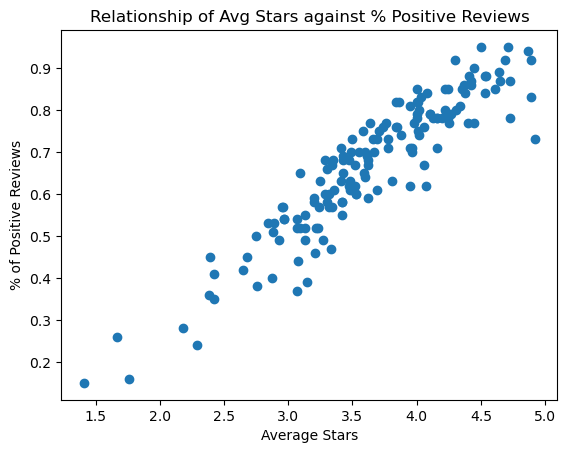

In [24]:
plt.scatter(sentiment_data['Avg Stars'], sentiment_data['% Positive Reviews'])
plt.title("Relationship of Avg Stars against % Positive Reviews")
plt.xlabel("Average Stars")
plt.ylabel("% of Positive Reviews")
plt.show()

From this graph, we can conclude that there is generally a linear correlation between the number of positive reviews and the average number of stars given by reviewers. 

Furthermore, this allows us to conclude that our model is able to predict the sentiment of reviews quite accurately. As such, we will be able to use it in our application.

---
## Functions to be used during runtime

Functions defined in this segment will be used during the application runtime

In [25]:
# to be used during runtime
def retrieveUniqueBusinessesByInput(userInput, es, index_name):
    doc_count = 0
    reviews = []
    query = {
        "size": 100,
        "query": {
            "match": {
                "text": userInput
            }
        }
    }
    
    # Make a search request
    res = es.search(index=index_name, body=query, scroll='2s')
    
    for doc in res['hits']['hits']:
        doc_count += 1
        reviews.append(doc['_source'])
    
    old_scroll_id = res['_scroll_id']
    
    while len(res['hits']['hits']):
        res = es.scroll(scroll_id=old_scroll_id, scroll='2s')
        old_scroll_id = res['_scroll_id']
        
        # Iterate over hits for each scroll
        for doc in res['hits']['hits']:
            doc_count += 1
            reviews.append(doc['_source'])
                        
    # From the reviews retrieved, extract X reviews, one from each unique business
    business_set = set()
    for review in reviews:
        business_set.add(review['business_id'])
        
    return list(business_set)

---

## Main Application

In this application, the main goal is for users to be able to retrieve businesses that are relevant to their search.
The application then returns a list of the Top 5 businesses that have the highest positive number of reviews.

These are the following steps that are taken in this application:
1. Take in user's input to search for their point of interest
2. Using the user's input and the index generated using Elastic Search, we generate all the businesses with a review that has the relevant word.
3. With the businesses generated, we then get the business sentiment using the pre-computed dictionary 'business_sentiment'
4. Lastly, we sort them in a descending order to get the Top 5 businesses relevant

In [26]:
def main():
    
    user_input = input("Please input your topic of interest: \n\nSearch: ")
    
    # Get the businesses
    unique_businesses = retrieveUniqueBusinessesByInput(user_input, es, index_name)
    
    search_results = {}
    # get sentiment of businesses with particular word
    for i in range(len(unique_businesses)):
        for key in business_sentiment:
            if key == unique_businesses[i]:
                search_results[key] = business_sentiment[key]
    
    sorted_results = sorted(search_results.items(), key=lambda t: t[::-1],reverse=True)
    
    print('Returning Top 5 businesses with relevant topic:', user_input)
    print()
    
    print('        Business            |      % of Positive Reviews')
    print('=============================================================')
    for key, value in sorted_results[:5]:
        print(key + '      |' + ' '*int((32 - len(str(round(value,2))))/2) + str(round(value, 2)))

main()

Please input your topic of interest: 

Search: chicken


<ipython-input-25-aa31fc00125d>:15: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  res = es.search(index=index_name, body=query, scroll='2s')
C:\Users\Grace\Anaconda3\envs\tensorflow_env\lib\site-packages\elasticsearch\connection\base.py:209: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.15/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


Returning Top 5 businesses with relevant topic: chicken

        Business            |      % of Positive Reviews
ZhACHVw9k438Z3i-Gw9BHA      |              0.92
6RbCJLiwNYwS6ab9vzD_zg      |              0.92
OjnRf8yDGEBCoUDdchSViw      |              0.9
hXzoNgpkC86K_Jfg_zMHvA      |              0.88
XA_m9daZl2VFDA6alnkBvg      |              0.88
